<a href="https://colab.research.google.com/github/efeecllk/investor-sentiments/blob/main/bitcoin_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 6.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import gensim
from sklearn.linear_model import LogisticRegression
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import string
import re
import emoji


In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
# Load Bitcoin Tweet Dataset
tweets_df = pd.read_csv('/content/drive/MyDrive/NLP/Bitcoin_tweets.csv', nrows=10000)

# Load Bitcoin Price Dataset
price_df = pd.read_csv('/content/drive/MyDrive/NLP/bitcoin_2017_to_2023.csv')



In [5]:
tweets_df.head()


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [6]:
price_df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611


In [7]:
import pandas as pd

# Convert dates and times
tweets_df['user_created'] = pd.to_datetime(tweets_df['user_created'], errors='coerce')
price_df['timestamp'] = pd.to_datetime(price_df['timestamp'], errors='coerce')

# Clean invalid values and sort by time
tweets_df = tweets_df.dropna(subset=['user_created']).sort_values(by='user_created')
price_df = price_df.dropna(subset=['timestamp']).sort_values(by='timestamp')

# Match timestamps while preserving all tweets
merged_df = pd.merge_asof(
    tweets_df,
    price_df,
    left_on='user_created',
    right_on='timestamp',
    direction='backward',
    tolerance=pd.Timedelta('1d')  # Maximum 1-day difference
)

# Calculate time difference (optional)
merged_df['time_difference'] = (merged_df['user_created'] - merged_df['timestamp']).abs()

# Check for unmatched rows
missing_matches = merged_df[merged_df['timestamp'].isna()]
print(f"Number of Unmatched Tweets: {len(missing_matches)}")

# Perform forward search for unmatched tweets
merged_df_forward = pd.merge_asof(
    tweets_df,
    price_df,
    left_on='user_created',
    right_on='timestamp',
    direction='forward',
    tolerance=pd.Timedelta('1d')
)

# Combine and remove duplicates
final_merged_df = pd.concat([merged_df, merged_df_forward]).drop_duplicates(subset=['user_created'])

# Check still unmatched rows
still_missing = final_merged_df[final_merged_df['timestamp'].isna()]
print(f"Number of Still Unmatched Tweets: {len(still_missing)}")

# Display results
print("\nMatched Tweet and Price Data:")
print(final_merged_df.head())

# Remove unmatched records (rows where 'timestamp' is NaN)
final_merged_df = final_merged_df.dropna(subset=['timestamp']).reset_index(drop=True)

# Verify the final dataset
print(f"Number of Unmatched Tweets After Removal: {final_merged_df['timestamp'].isna().sum()}")
print("\nMatched Tweet and Price Data (Unmatched Removed):")
print(final_merged_df.head())


Number of Unmatched Tweets: 3969
Number of Still Unmatched Tweets: 1802

Matched Tweet and Price Data:
        user_name         user_location  \
0       Greg Kidd       Crystal Bay, NV   
1     Yaron Samid              Tel Aviv   
2  Travis Russell                   NaN   
3   ngc_3370 LION       ngc_3370 Galaxy   
4  Justin Roberti  Nonspecificville, PA   

                                    user_description        user_created  \
0  CEO GlobaliD (@myglobal_id), co-founder Hard Y... 2006-04-01 03:32:37   
1  3X dad, 3X founder, investor and community bui... 2006-12-04 19:48:28   
2  #Bitcoin | Aquaponics | Padres | https://t.co/... 2007-01-26 19:40:36   
3  “As soon as you stop wanting or dreaming somet... 2007-03-12 07:41:16   
4  Writer & podcast producer - Games, tech, finte... 2007-04-03 01:57:06   

   user_followers  user_friends  user_favourites  user_verified  \
0         12868.0           132              417          False   
1          4792.0           140             124

In [8]:
# Remove unmatched records (rows where 'timestamp' is NaN)
final_merged_df = final_merged_df.dropna(subset=['timestamp']).reset_index(drop=True)

# Verify the final dataset
print(f"Number of Unmatched Tweets After Removal: {final_merged_df['timestamp'].isna().sum()}")
print("\nMatched Tweet and Price Data (Unmatched Removed):")
print(final_merged_df.head())
merged_df = final_merged_df

Number of Unmatched Tweets After Removal: 0

Matched Tweet and Price Data (Unmatched Removed):
        user_name        user_location  \
0  Michael Arouet  Somewhere in Europe   
1       athcrypt℗              Croatia   
2     Wickhunterr                India   
3           Kayth               Europe   
4  The 1 i Am Neo      Los Angeles, CA   

                                    user_description        user_created  \
0  Independent investor, correlation deviations b... 2017-08-17 11:22:22   
1  MIT / UX & Product Designer / $BTC $ETH $DOGE ... 2017-08-18 09:29:07   
2  Pure Technical Analyst 🔥\nTrading Crypto since... 2017-08-18 14:19:50   
3                  Software Engineer. #Bitcoin only. 2017-08-18 16:40:28   
4                                     Bitcoin Trader 2017-08-18 17:36:59   

   user_followers  user_friends  user_favourites  user_verified  \
0           795.0           482             1530          False   
1           413.0           396            23026          Fal

In [9]:
merged_df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,...,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,time_difference
0,Michael Arouet,Somewhere in Europe,"Independent investor, correlation deviations b...",2017-08-17 11:22:22,795.0,482,1530,False,2021-02-09 22:34:39,"#Bitcoin unrealized losses must be recognized,...",...,4474.80,4474.80,4474.80,4474.80,0.000000,0.000000,0.0,0.000000,0.000000,0 days 00:00:22
1,athcrypt℗,Croatia,MIT / UX & Product Designer / $BTC $ETH $DOGE ...,2017-08-18 09:29:07,413.0,396,23026,False,2021-02-09 07:20:41,Hacked with nudes #blockfolio @blockfolio #btc...,...,4321.20,4327.25,4307.01,4307.01,0.369231,1595.893279,7.0,0.086659,374.904408,0 days 00:00:07
2,Wickhunterr,India,Pure Technical Analyst 🔥\nTrading Crypto since...,2017-08-18 14:19:50,80.0,167,1356,False,2021-02-10 00:05:25,The So called Next BTC is waking up\n\n#YFI #D...,...,4272.92,4272.92,4272.92,4272.92,0.107711,460.240486,1.0,0.107711,460.240486,0 days 00:00:50
3,Kayth,Europe,Software Engineer. #Bitcoin only.,2017-08-18 16:40:28,40.0,428,1628,False,2021-02-08 19:07:28,If you want to create a bitcoin seed with dice...,...,4266.72,4266.72,4266.72,4266.72,0.060301,257.287483,1.0,0.060301,257.287483,0 days 00:00:28
4,The 1 i Am Neo,"Los Angeles, CA",Bitcoin Trader,2017-08-18 17:36:59,142.0,95,3,False,2021-02-08 16:37:20,#Bitcoin #BTC #btcusd $btc https://t.co/lAMPlm...,...,4126.45,4126.45,4126.45,4126.45,0.000000,0.000000,0.0,0.000000,0.000000,0 days 00:00:59


In [10]:
merged_df = merged_df.drop('user_location', axis=1)

In [11]:
merged_df.columns

Index(['user_name', 'user_description', 'user_created', 'user_followers',
       'user_friends', 'user_favourites', 'user_verified', 'date', 'text',
       'hashtags', 'source', 'is_retweet', 'timestamp', 'open', 'high', 'low',
       'close', 'volume', 'quote_asset_volume', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
       'time_difference'],
      dtype='object')

In [12]:
merged_df.shape[0]

2415

In [13]:
def preprocess_text(text):
    text = emoji.demojize(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])
    return text



In [14]:
len(merged_df)

2415

In [15]:
merged_df['text'] = merged_df['text'].apply(preprocess_text)


In [16]:
merged_df.head()

,user_name,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,...,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,time_difference
0,Michael Arouet,"Independent investor, correlation deviations b...",2017-08-17 11:22:22,795.0,482,1530,False,2021-02-09 22:34:39,bitcoin unrealized loss must recognized unreal...,"['Bitcoin', 'BTC']",...,4474.80,4474.80,4474.80,4474.80,0.000000,0.000000,0.0,0.000000,0.000000,0 days 00:00:22
1,athcrypt℗,MIT / UX & Product Designer / $BTC $ETH $DOGE ...,2017-08-18 09:29:07,413.0,396,23026,False,2021-02-09 07:20:41,hacked nude blockfolio blockfolio btc bitcoin ...,"['blockfolio', 'btc', 'bitcoin', 'ethereum']",...,4321.20,4327.25,4307.01,4307.01,0.369231,1595.893279,7.0,0.086659,374.904408,0 days 00:00:07
2,Wickhunterr,Pure Technical Analyst 🔥\nTrading Crypto since...,2017-08-18 14:19:50,80.0,167,1356,False,2021-02-10 00:05:25,called next btc waking yfi defi btc binance bi...,"['YFI', 'DeFi', 'BTC', 'Binance', 'Bitcoin', '...",...,4272.92,4272.92,4272.92,4272.92,0.107711,460.240486,1.0,0.107711,460.240486,0 days 00:00:50
3,Kayth,Software Engineer. #Bitcoin only.,2017-08-18 16:40:28,40.0,428,1628,False,2021-02-08 19:07:28,want create bitcoin seed dice roll time roll d...,NaN,...,4266.72,4266.72,4266.72,4266.72,0.060301,257.287483,1.0,0.060301,257.287483,0 days 00:00:28
4,The 1 i Am Neo,Bitcoin Trader,2017-08-18 17:36:59,142.0,95,3,False,2021-02-08 16:37:20,bitcoin btc btcusd btc httpstcolamplmodt live ...,"['Bitcoin', 'BTC', 'btcusd']",...,4126.45,4126.45,4126.45,4126.45,0.000000,0.000000,0.0,0.000000,0.000000,0 days 00:00:59


In [17]:
import gensim
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pickle


In [18]:
# Word2Vec modelini yükle
word2vec_model = gensim.models.Word2Vec.load('/content/drive/MyDrive/NLP/word2vec_model.model')


In [19]:
# Rastgele bir kelimenin vektörünü kontrol edin
print(word2vec_model.wv['good'] if 'good' in word2vec_model.wv else "Kelime bulunamadı")


[ 2.8839207   1.3391731   7.308303    1.8964574  -2.3862646  -2.4070337
 -2.7014947  -1.3842946   0.6010865   0.47718966 -2.0427055   0.0712805
 -1.2981845   0.83583057 -1.9568009  -1.2591379  -1.8955985   4.1568966
 -1.5634154  -0.6319844  -0.16744928 -3.7785995  -2.6053498   1.0011839
  0.93321794 -0.07429277  0.43825418 -1.973161   -2.0896351  -0.33100697
 -2.007238   -0.20221233 -1.5455337   0.40533808  2.1798923  -1.7087928
  0.23598431 -1.2951624   0.58126557 -1.4197496   0.13569267 -1.1923347
  2.2944686   3.099303    2.904183    1.4573932   1.0067637   3.9175096
 -0.26833215  1.7419922   1.2856376   0.20880349  2.3304741   1.0495452
  3.0477738  -1.6131055  -0.7979749  -2.163896   -1.4567354   0.58822817
  1.6011333   1.1501036   1.5040768  -0.08322735  0.32401174  0.34224036
 -3.588203   -1.3385513  -0.512516    1.4993126   2.9119456  -0.11238984
 -1.8974228  -1.3987986   2.0573664  -3.158226   -0.19347374 -0.09233224
 -3.0921054  -7.14259     1.5415266  -1.0819113   2.4227936

In [20]:
import joblib
logistic_model = joblib.load('/content/drive/MyDrive/NLP/llogistic_model.pkl')
def sentiment_analysis(text):
    vector = text_to_word2vec(text, word2vec_model)
    sentiment = logistic_model.predict([vector])[0]
    return sentiment


In [24]:
def text_to_word2vec(text, model):
    """Converts a text string into a word2vec vector representation.

    Args:
        text (str): The input text.
        model (gensim.models.Word2Vec): The trained Word2Vec model.

    Returns:
        np.ndarray: The average word2vec vector for the input text.
    """
    words = text.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [25]:

merged_df['sentiment_label'] = merged_df['text'].apply(lambda x: sentiment_analysis(x))

# Display sample rows with sentiment labels
print("\nDataset with Sentiment Labels:")
print(merged_df[['text', 'sentiment_label']].head())



Dataset with Sentiment Labels:
                                                text  sentiment_label
0  bitcoin unrealized loss must recognized unreal...                2
1  hacked nude blockfolio blockfolio btc bitcoin ...                0
2  called next btc waking yfi defi btc binance bi...                1
3  want create bitcoin seed dice roll time roll d...                1
4  bitcoin btc btcusd btc httpstcolamplmodt live ...                0


In [26]:
merged_df.columns

Index(['user_name', 'user_description', 'user_created', 'user_followers',
       'user_friends', 'user_favourites', 'user_verified', 'date', 'text',
       'hashtags', 'source', 'is_retweet', 'timestamp', 'open', 'high', 'low',
       'close', 'volume', 'quote_asset_volume', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
       'time_difference', 'sentiment_label'],
      dtype='object')

In [ ]:
#######################

In [27]:

# Define the mapping dictionary
label_mapping = {0: 'Neutral', 1: 'Bullish', 2: 'Bearish'}

# Apply mapping to the 'label' column
merged_df['sentiment_label_name'] = merged_df['sentiment_label'].map(label_mapping)

# Verify if mapping was successful
print(merged_df[['sentiment_label', 'sentiment_label_name']].head())


   sentiment_label sentiment_label_name
0                2              Bearish
1                0              Neutral
2                1              Bullish
3                1              Bullish
4                0              Neutral


In [28]:
merged_df.columns

Index(['user_name', 'user_description', 'user_created', 'user_followers',
       'user_friends', 'user_favourites', 'user_verified', 'date', 'text',
       'hashtags', 'source', 'is_retweet', 'timestamp', 'open', 'high', 'low',
       'close', 'volume', 'quote_asset_volume', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
       'time_difference', 'sentiment_label', 'sentiment_label_name'],
      dtype='object')

sentiment_label_name
Bullish    1319
Neutral     579
Bearish     517
Name: count, dtype: int64


<ipython-input-29-7fb80d3e3e51>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='sentiment_label_name', palette='viridis')


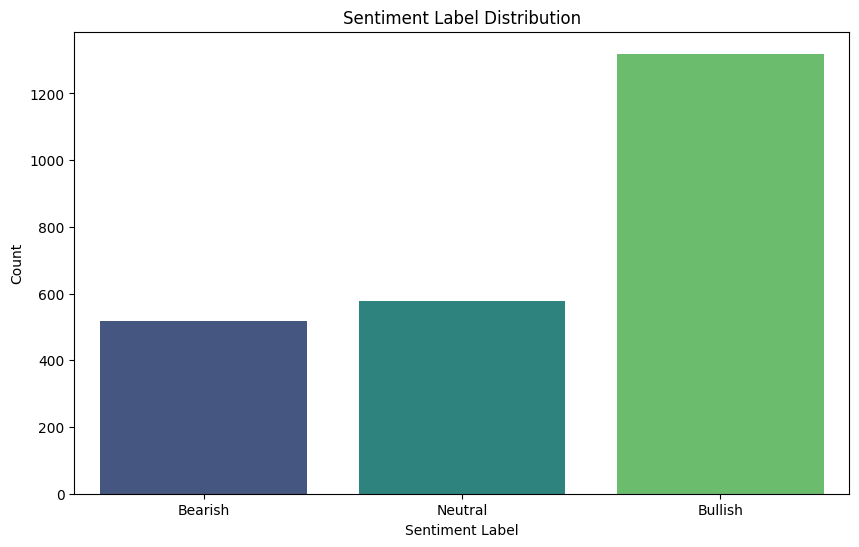

In [29]:
# Cell 3: Sentiment Label Distribution

import seaborn as sns
import matplotlib.pyplot as plt

# Display distribution
print(merged_df['sentiment_label_name'].value_counts())

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='sentiment_label_name', palette='viridis')
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()


In [31]:
merged_df['week'] = pd.to_datetime(merged_df['date']).dt.to_period('W').dt.start_time

weekly_sentiment = merged_df.groupby('week')['sentiment_label_name'].value_counts().unstack(fill_value=0)

weekly_sentiment['positive_negative_ratio'] = weekly_sentiment['Bullish'] / (weekly_sentiment['Bearish'] + 1)

weekly_price = price_df.resample('W', on='timestamp').last()
weekly_sentiment = weekly_sentiment.merge(weekly_price[['timestamp', 'close']],
                                          left_on='week', right_on='timestamp',
                                          how='left')

correlation = weekly_sentiment['positive_negative_ratio'].corr(weekly_sentiment['close'])
print(f"Korelasyon (Haftalık): {correlation}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(weekly_sentiment['week'], weekly_sentiment['positive_negative_ratio'], label='Haftalık Pozitif-Negatif Oranı')
plt.plot(weekly_sentiment['week'], weekly_sentiment['close'], label='Haftalık Fiyat Kapanışı')
plt.legend()
plt.title('Haftalık Pozitif-Negatif Oranı ve Fiyat İlişkisi')
plt.show()


Korelasyon (Haftalık): nan


KeyError: 'week'

<Figure size 1200x600 with 0 Axes>

## User Influence Score

In [40]:
# Influence Score hesaplama
merged_df['user_verified_score'] = merged_df['user_verified'].apply(lambda x: 2 if x else 1)
merged_df['is_retweet_score'] = merged_df['is_retweet'].apply(lambda x: 1 if x else 0)

# Ağırlıklandırılmış Etki Skoru
merged_df['influence_score'] = (
    0.4 * merged_df['user_followers'] +
    0.2 * merged_df['user_favourites'] +
    0.2 * merged_df['is_retweet_score'] +
    0.2 * merged_df['user_verified_score']
)


In [41]:
import networkx as nx

# Ağ Grafiği Oluştur
G = nx.from_pandas_edgelist(merged_df, source='user_name', target='is_retweet', create_using=nx.DiGraph())

# PageRank Hesapla
pagerank_scores = nx.pagerank(G)
pagerank_df = pd.DataFrame(pagerank_scores.items(), columns=['user_name', 'pagerank_score'])

# PageRank Skorunu Birleştir
merged_df = pd.merge(merged_df, pagerank_df, on='user_name', how='left')

# En Etkili Kullanıcılar
top_influencers = merged_df.groupby('user_name')['influence_score'].mean().sort_values(ascending=False).head(10)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119813 (\N{MATHEMATICAL BOLD CAPITAL F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119842 (\N{MATHEMATICAL BOLD SMALL I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119847 (\N{MATHEMATICAL BOLD SMALL N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119834 (\N{MATHEMATICAL BOLD SMALL A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119859 (\N{MATHEMATICAL BOLD SMALL Z}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/us

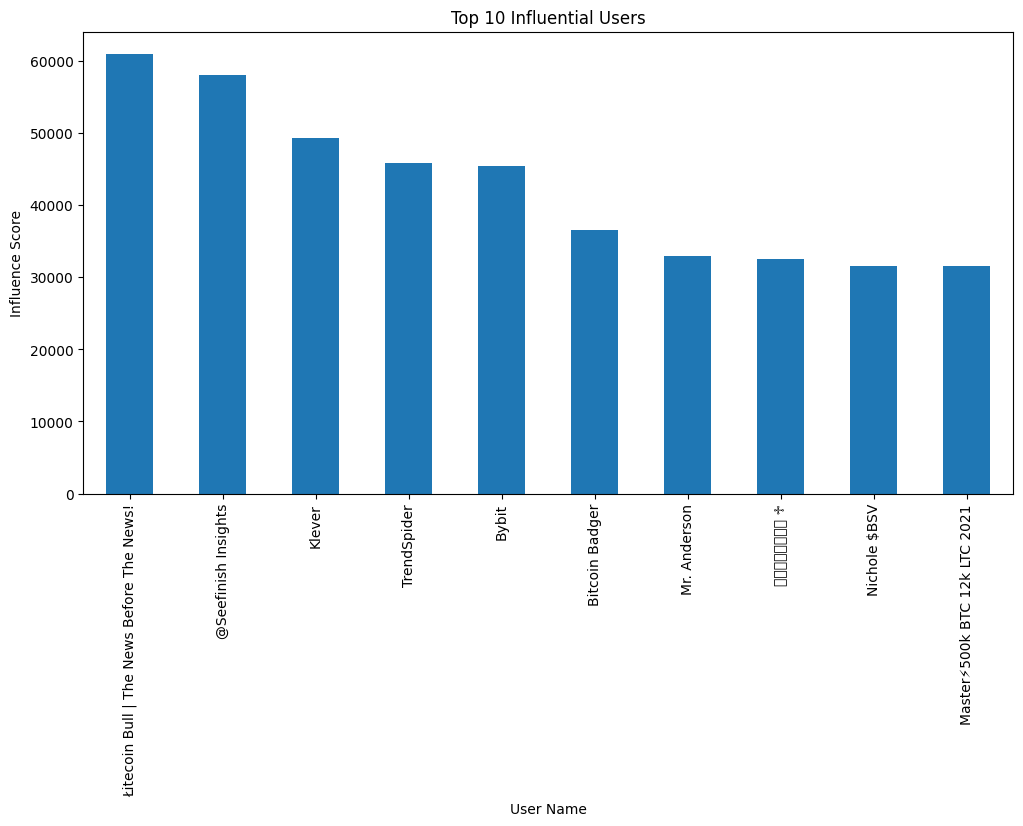

In [42]:
# Barplot Görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
top_influencers.plot(kind='bar')
plt.title('Top 10 Influential Users')
plt.xlabel('User Name')
plt.ylabel('Influence Score')
plt.show()


### *BTC PRICE GUESS*

In [36]:
# Fiyat Değişimini Belirleme
merged_df['price_trend'] = merged_df.apply(
    lambda row: 'up' if row['close'] > row['open'] else ('down' if row['close'] < row['open'] else 'neutral'),
    axis=1
)


In [37]:
# Kullanıcının Tahmin Doğruluğu
def check_prediction(row):
    if row['sentiment_label'] == 1 and row['price_trend'] == 'up':
        return 'correct'
    elif row['sentiment_label'] == 2 and row['price_trend'] == 'down':
        return 'correct'
    elif row['sentiment_label'] == 0 and row['price_trend'] == 'neutral':
        return 'correct'
    else:
        return 'wrong'

merged_df['prediction_accuracy'] = merged_df.apply(check_prediction, axis=1)


In [49]:
# Tahminlerin Sayısını Hesaplama
prediction_counts = merged_df['prediction_accuracy'].value_counts().reset_index()
prediction_counts.columns = ['Prediction Accuracy', 'Count']

# Sonuçları Görüntüleme
print(prediction_counts)


  Prediction Accuracy  Count
0               wrong   1514
1             correct    901


In [50]:
# Correct ve Wrong Tahminler için Influence Score Ortalaması
correct_avg_influence = merged_df[merged_df['prediction_accuracy'] == 'correct']['influence_score'].mean()
wrong_avg_influence = merged_df[merged_df['prediction_accuracy'] == 'wrong']['influence_score'].mean()

# Sonuçları Yazdır
print(f"Correct Tahminlerin Ortalama Influence Score'u: {correct_avg_influence:.2f}")
print(f"Wrong Tahminlerin Ortalama Influence Score'u: {wrong_avg_influence:.2f}")


Correct Tahminlerin Ortalama Influence Score'u: 1304.65
Wrong Tahminlerin Ortalama Influence Score'u: 1250.25


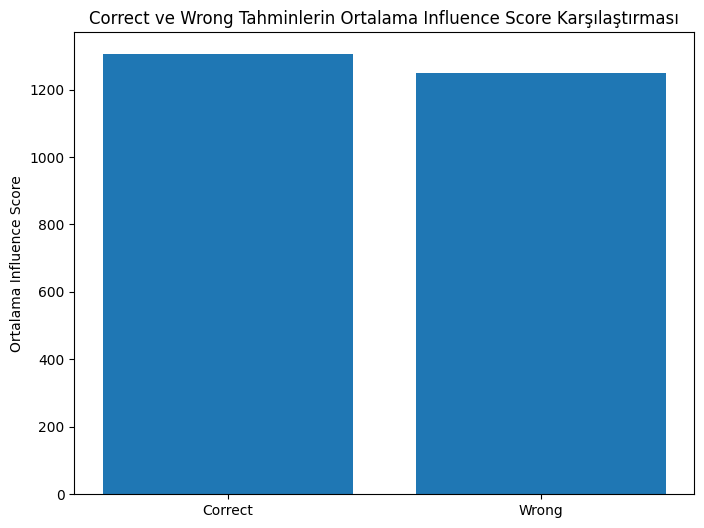

In [51]:
import matplotlib.pyplot as plt

# Veriyi Hazırlama
avg_scores = {
    'Correct': correct_avg_influence,
    'Wrong': wrong_avg_influence
}

# Bar Grafiği
plt.figure(figsize=(8, 6))
plt.bar(avg_scores.keys(), avg_scores.values())
plt.title('Correct ve Wrong Tahminlerin Ortalama Influence Score Karşılaştırması')
plt.ylabel('Ortalama Influence Score')
plt.show()


In [45]:
# Kullanıcı Bazlı Doğruluk Oranı
user_accuracy = merged_df.groupby('user_name')['prediction_accuracy'].apply(
    lambda x: (x == 'correct').mean()
).reset_index()
user_accuracy.columns = ['user_name', 'accuracy_score']

# Ana Veri Setine Ekle
merged_df = pd.merge(merged_df, user_accuracy, on='user_name', how='left')

# Güvenilirlik Etiketi
merged_df['trustworthiness'] = merged_df['accuracy_score'].apply(
    lambda x: 'Trust' if x >= 0.6 else 'DONT_Trust'
)


In [46]:
merged_df['trustworthiness']

,trustworthiness
0,DONT_Trust
1,DONT_Trust
2,DONT_Trust
3,DONT_Trust
4,Trust
...,...
2410,DONT_Trust
2411,DONT_Trust
2412,DONT_Trust
2413,DONT_Trust


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


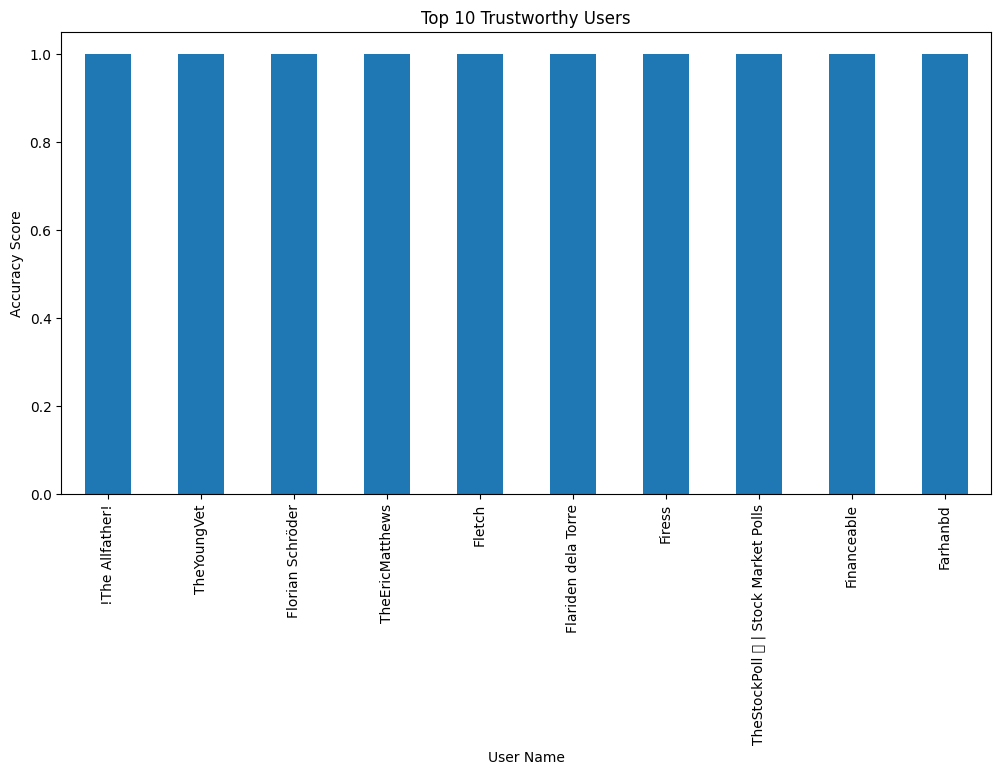

In [39]:
# En Güvenilir Kullanıcılar
top_trustworthy_users = merged_df.groupby('user_name')['accuracy_score'].mean().sort_values(ascending=False).head(10)

# Barplot Görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
top_trustworthy_users.plot(kind='bar')
plt.title('Top 10 Trustworthy Users')
plt.xlabel('User Name')
plt.ylabel('Accuracy Score')
plt.show()
